# 🔥 Fire and Smoke Detection System using YOLOv12 🚒

In the face of increasing fire hazards, early detection is crucial for saving lives and property. This notebook presents a robust **Fire and Smoke Detection System** leveraging the power of **YOLOv12**, the latest iteration in the YOLO family of real-time object detectors.

### 🎯 Objective
The primary goal is to train a model that can accurately identify and classify **Fire** and **Smoke** in images and video streams. We will walk through the entire pipeline:
1.  **Data Preparation**: Cleaning and organizing the dataset.
2.  **Configuration**: Setting up data paths for YOLO.
3.  **Visualization**: Inspecting the data.
4.  **Training**: Fine-tuning YOLOv12.
5.  **Validation**: Evaluating the model's performance.

Let's dive in! 🚀


## 🤖 Understanding YOLO (You Only Look Once)

**YOLO (You Only Look Once)** is a groundbreaking approach to object detection that transformed the field by reframing detection as a **single regression problem**, rather than a complex pipeline of region proposals and classifiers (like R-CNN).

### 🔑 Key Concepts:
1.  **Single Pass Efficiency**: As the name implies, YOLO "looks" at the image only once. It processes the entire image through a neural network in a single forward pass, making it exceptionally fast and suitable for real-time applications.
2.  **Grid System**: The input image is divided into an $S \times S$ grid. If the center of an object falls into a grid cell, that cell is responsible for detecting it.
3.  **Bounding Box Regression**: Each grid cell predicts $B$ bounding boxes and confidence scores for those boxes. The confidence score reflects how likely the box contains an object and how accurate the box is: $Pr(Object) \times IOU_{pred}^{truth}$.
4.  **Class Probabilities**: Each grid cell also predicts conditional class probabilities $Pr(Class_i | Object)$.

**Why YOLOv12?**
YOLOv12 builds upon this foundation with architectural improvements for better feature extraction, handling of small objects (like distant smoke), and optimized loss functions, achieving state-of-the-art accuracy with minimal latency.


## 1. 📚 Import Libraries
First, we import the necessary Python libraries for file handling (`os`, `shutil`, `csv`), image processing (`cv2`, `numpy`), and visualization (`matplotlib`).


In [1]:
import csv
import shutil
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path

## 2. ⚙️ Configuration and Paths
Here we define the root directories for our dataset and set up paths where the cleaned data and reports will be saved. We segregate bad images to avoid polluting the training set.


In [2]:
ROOT = "/kaggle/input/smoke-fire-detection-yolo/data"
BAD_IMAGES_DIR = "/kaggle/working/bad_images"
BAD_LABELS_DIR = "/kaggle/working/bad_labels"
CLEAN_ROOT = "/kaggle/working/clean_data"
REPORT_CSV = "/kaggle/working/data_clean_report.csv"

## 3. 🧹 Data Cleaning: Identifying Bad Images
We define a list of specific images that are known to be corrupted, incorrectly labeled, or unsuitable for training. These will be filtered out in the next step.


In [3]:
bad_list = [
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/PublicDataset01005.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/PublicDataset00864.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB04185.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB02767.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/PublicDataset01036.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/PublicDataset00934.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB06024.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB02729.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB06022.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB06334.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB04554.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB06336.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB03587.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/WEB06082.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/train/images/PublicDataset00900.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB02650.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/val/images/WEB02614.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/val/images/PublicDataset01007.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/test/images/WEB10194.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/test/images/WEB10116.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/test/images/WEB10972.jpg",
    "/kaggle/input/smoke-fire-detection-yolo/data/test/images/WEB10874.jpg",
]

## 4. 🔄 Processing and Cleaning Data
This is the core data preparation step. We iterate through the `train`, `val`, and `test` splits.
-   We verify if images exist and are valid.
-   We check if they are in our `bad_list`.
-   Valid images and their labels are copied to a `clean_data` directory.
-   Issues are logged for our report.


In [4]:
os.makedirs(BAD_IMAGES_DIR, exist_ok=True)
os.makedirs(BAD_LABELS_DIR, exist_ok=True)

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(CLEAN_ROOT, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(CLEAN_ROOT, split, "labels"), exist_ok=True)

report_rows = []

for split in ["train", "val", "test"]:
    src_img_dir = os.path.join(ROOT, split, "images")
    src_lbl_dir = os.path.join(ROOT, split, "labels")
    dst_img_dir = os.path.join(CLEAN_ROOT, split, "images")
    dst_lbl_dir = os.path.join(CLEAN_ROOT, split, "labels")

    if not os.path.isdir(src_img_dir):
        print("Missing dir:", src_img_dir)
        continue

    for fname in sorted(os.listdir(src_img_dir)):
        src_img = os.path.join(src_img_dir, fname)

        if not os.path.isfile(src_img):
            continue

        name, _ = os.path.splitext(fname)
        src_label = os.path.join(src_lbl_dir, name + ".txt")

        if src_img in bad_list:
            shutil.copy2(src_img, BAD_IMAGES_DIR)

            if os.path.exists(src_label):
                shutil.copy2(src_label, BAD_LABELS_DIR)
                report_rows.append([split, fname, "bad_image_and_label_copied"])
            else:
                report_rows.append([split, fname, "bad_image_copied_label_missing"])
            continue

        img = cv2.imread(src_img)

        if img is None or img.size == 0:
            print(f"Invalid image: {src_img}")
            shutil.copy2(src_img, BAD_IMAGES_DIR)

            if os.path.exists(src_label):
                shutil.copy2(src_label, BAD_LABELS_DIR)
                report_rows.append([split, fname, "corrupted_image_and_label_copied"])
            else:
                report_rows.append([split, fname, "corrupted_image_copied_label_missing"])
            continue

        shutil.copy2(src_img, dst_img_dir)

        if os.path.exists(src_label):
            shutil.copy2(src_label, dst_lbl_dir)
            report_rows.append([split, fname, "copied_with_label"])
        else:
            report_rows.append([split, fname, "copied_label_missing"])

print("=" * 50)

for split in ["train", "val", "test"]:
    clean_dir = os.path.join(CLEAN_ROOT, split, "images")
    if os.path.exists(clean_dir):
        print(f"{split}: {len(os.listdir(clean_dir))} Valid Images")

train: 14107 Valid Images
val: 3096 Valid Images
test: 4302 Valid Images


## 5. 📝 Saving the Cleaning Report
After processing, we print a summary of how many valid images we have for each split and save a detailed CSV report of the actions taken on invalid files.


In [5]:
print("=" * 50)
print(f"   Invlaid Images Save Her {BAD_IMAGES_DIR}")
print(f" Invlaid Labels Save Her: {BAD_LABELS_DIR}")

with open(REPORT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["split", "filename", "action"])
    w.writerows(report_rows)

   Invlaid Images Save Her /kaggle/working/bad_images
 Invlaid Labels Save Her: /kaggle/working/bad_labels


## 6. 📄 Creating Dataset Configuration
YOLO requires a YAML file to understand the dataset structure. We create `data.yaml` which specifies:
-   Paths to `train`, `val`, and `test` images.
-   Number of classes (`nc: 2`).
-   Class names (`['smoke', 'fire']`).


In [6]:
yaml_text = f"""train: {CLEAN_ROOT}/train/images
val: {CLEAN_ROOT}/val/images
test: {CLEAN_ROOT}/test/images

nc: 2
names: ['smoke','fire']
"""
with open("/kaggle/working/data.yaml", "w", encoding="utf-8") as yf:
    yf.write(yaml_text)

print("dat.yaml is Done Created")

dat.yaml is Done Created


## 7. 👁️ Visualizing Sample Data
It's important to inspect our data before training. This block picks random samples from the training set and plots them with their bounding boxes to ensure labels are correct.


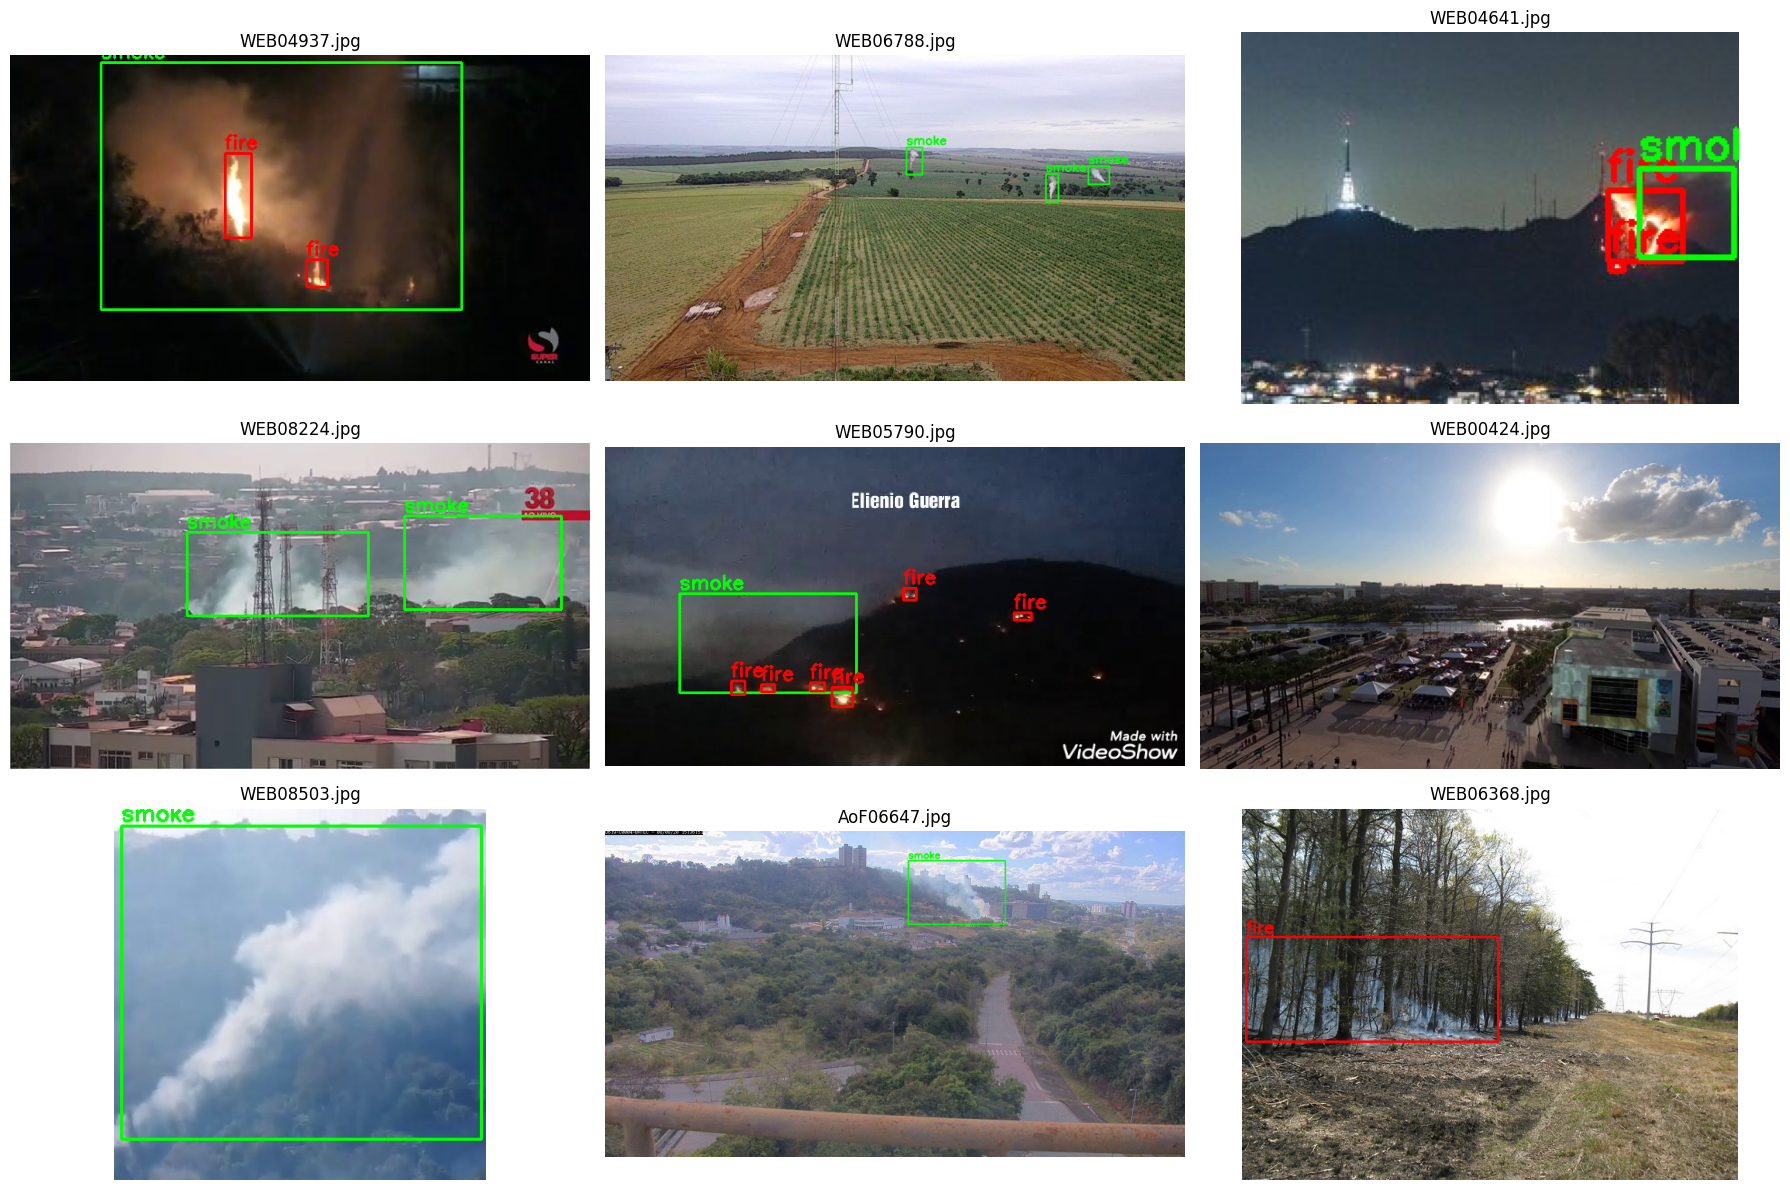

In [7]:


train_img_path = "/kaggle/input/smoke-fire-detection-yolo/data/train/images"
train_label_path = "/kaggle/input/smoke-fire-detection-yolo/data/train/labels"

sample_imgs = random.sample(os.listdir(train_img_path), 9)

def plot_image_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    label_file = label_path.replace('.jpg', '.txt').replace('.png', '.txt')
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f.readlines():
                cls, x_center, y_center, bw, bh = map(float, line.strip().split())
                x1 = int((x_center - bw/2) * w)
                y1 = int((y_center - bh/2) * h)
                x2 = int((x_center + bw/2) * w)
                y2 = int((y_center + bh/2) * h)
                color = (0, 255, 0) if cls == 0 else (0, 0, 255)
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cls_name = "smoke" if cls == 0 else "fire"
                cv2.putText(img, cls_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

plt.figure(figsize=(18, 12))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(train_img_path, img_name)
    label_path = os.path.join(train_label_path, img_name)
    plt.subplot(3, 3, i+1)
    plt.imshow(plot_image_with_boxes(img_path, label_path))
    plt.axis('off')
    plt.title(img_name)
plt.tight_layout()
plt.show()

## 8. 🛠️ Installing Dependencies
We install the `ultralytics` package, which provides the YOLO implementation we will be using.


In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:0000:0100:01


## 9. 📦 Importing YOLO
We import the `YOLO` class from the `ultralytics` library to begin working with the model.


In [9]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 10. 🚀 Initializing the YOLO Model
We load the **YOLOv12n** (nano) model. The 'nano' version is lightweight and fast, making it a great starting point.


In [10]:
model = YOLO("yolo12n.pt")

## 11. 🏋️ Training the Model
We assume the model training is initiated here directly.


In [11]:
results = model.train(data="/kaggle/working/data.yaml",epochs=60,imgsz=640,verbose=True)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

## 12. 🏆 Validating the Model
Finally, we run validation on the trained model to assess its performance on unseen data.


In [12]:
model.val()

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1938.7±1270.7 MB/s, size: 132.3 KB)
val: Scanning /kaggle/working/clean_data/val/labels.cache... 3096 images, 1373 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3096/3096 4.2Mit/s 0.0s0s
val: /kaggle/working/clean_data/val/images/WEB07535.jpg: corrupt JPEG restored and saved
val: /kaggle/working/clean_data/val/images/WEB07536.jpg: corrupt JPEG restored and saved
val: /kaggle/working/clean_data/val/images/WEB07539.jpg: corrupt JPEG restored and saved
val: /kaggle/working/clean_data/val/images/WEB07542.jpg: corrupt JPEG restored and saved
val: /kaggle/working/clean_data/val/images/WEB07561.jpg: corrupt JPEG restored and saved
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 194/194 10.5it/s 18.4s.1ss
                   a

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cc7bb4ff950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804